In [1]:
%load_ext autoreload
%autoreload 2
    
import gc
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torchvision
import sys

# To view tensorboard metrics
# tensorboard --logdir=logs --port=6006 --bind_all
from torch.utils.tensorboard import SummaryWriter
from functools import partial
from evolver import CrossoverType, MutationType, InitType, VectorEvolver, MatrixEvolver
from unet import UNet
from dataset_utils import PartitionType
from cuda_utils import maybe_get_cuda_device, clear_cuda
from landcover_dataloader import get_landcover_dataloaders

from ignite.contrib.handlers.tensorboard_logger import *
from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, ConfusionMatrix, mIoU
from ignite.handlers import ModelCheckpoint
from ignite.utils import setup_logger
from ignite.engine import Engine

In [ ]:
evolver = MatrixEvolver([[4, 4]], CrossoverType.UNIFORM,
                            MutationType.FLIP_BIT, 
                            InitType.RANDOM, 
                            flip_bit_prob=0.2, 
                            flip_bit_decay=0.9,
                            binomial_prob=0.8)

template = np.array([
    [1, 0, 0, 1],
    [0, 1, 0, 0],
    [0, 0, 1, 1],
    [1, 0, 0, 1],
])
num_generations = 100
num_children = 200
for gen in range(0, num_generations):
    print(evolver.flip_bit_prob)
    for child_num in range(0, num_children):
        child = evolver.spawn_child()
        loss = 1.0 / np.sum(np.abs(child - template))
        if gen == num_generations - 1:
            print(gen, child_num, loss)
            print(child)
        evolver.add_child(child, loss)
    evolver.update_parents()

RAND
RAND


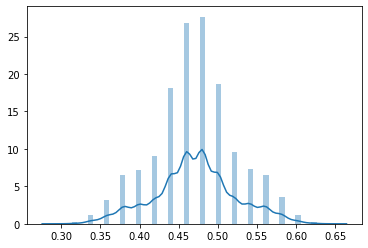

In [9]:
s = 50
evolver = VectorEvolver(s, 
                        crossover_type = CrossoverType.SINGLE_POINT,
                        mutation_type = MutationType.FLIP_BIT, 
                        init_type = InitType.RANDOM, 
                        flip_bit_prob=0, 
                        flip_bit_decay=1,
                        binomial_prob=0)
a = []
for i in range(0, 10000):
    cross = evolver.crossover(evolver._parents[0], evolver._parents[1])
    mutate = evolver.mutate(cross)
    a.append(np.count_nonzero(mutate) / float(s))
    
import matplotlib.pyplot as plt
import seaborn as sns

sns.distplot(a)

In [14]:
min(a)

0.3

In [12]:
np.count_nonzero(evolver._parents[1])

22

In [ ]:
print(evolver._parents[0], evolver._parents[1])
for i in range(0, 10):
    print(evolver.crossover(evolver._parents[0], evolver._parents[1]))

In [ ]:
# Define directories for data, logging and model saving.
base_dir = os.getcwd()
dataset_name = "landcover_large"
dataset_dir = os.path.join(base_dir, "data/" + dataset_name)

experiment_name = "dropout_finetuning"
model_name = "best_model_30_validation_accuracy=0.9409.pt"
model_path = os.path.join(base_dir, "logs/" + dataset_name + "/" + model_name)
log_dir = os.path.join(base_dir, "logs/" + dataset_name + "_" + experiment_name)

# Create DataLoaders for each partition of Landcover data.
dataloader_params = {
    'batch_size': 16,
    'shuffle': True,
    'num_workers': 6,
    'pin_memory': True}

partition_types = [PartitionType.TRAIN, PartitionType.VALIDATION, 
                   PartitionType.FINETUNING, PartitionType.TEST]
data_loaders = get_landcover_dataloaders(dataset_dir, 
                                         partition_types,
                                         dataloader_params,
                                         force_create_dataset=False)

train_loader = data_loaders[0]
finetuning_loader = data_loaders[2]
test_loader = data_loaders[3]

# Get GPU device if available.
device = maybe_get_cuda_device()

# Determine model and training params.
params = {
    'max_epochs': 10,
    'n_classes': 4,
    'in_channels': 4,
    'depth': 5,
    'learning_rate': 0.01,
    'log_steps': 1,
    'save_top_n_models': 4,
    'num_children': 3
}

clear_cuda()    
model = UNet(in_channels = params['in_channels'],
             n_classes = params['n_classes'],
             depth = params['depth'])
model.load_state_dict(torch.load(model_path))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), 
                             lr=params['learning_rate'])

# Determine metrics for evaluation.
train_metrics = {
        "accuracy": Accuracy(), 
        "loss": Loss(criterion),
        "mean_iou": mIoU(ConfusionMatrix(num_classes = params['n_classes'])),
        }

validation_metrics = {
        "accuracy": Accuracy(), 
        "loss": Loss(criterion),
        "mean_iou": mIoU(ConfusionMatrix(num_classes = params['n_classes'])),

}

for batch in train_loader:
    batch_x = batch[0]
    _ = model(batch_x)
    break
    
drop_out_layers = model.get_dropout_layers()
del model, batch_x
clear_cuda()


In [ ]:
global_best_child = None
for layer in drop_out_layers:
    if layer.name != "down_4":
        continue

    layer_name = layer.name
    size = layer.x_size[1:]
    sizes = [size]
    clear_cuda()    
    model = UNet(in_channels = params['in_channels'],
                 n_classes = params['n_classes'],
                 depth = params['depth'])
    model.load_state_dict(torch.load(model_path))

    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), 
                                 lr=params['learning_rate'])

    evolver = MatrixEvolver(sizes, 
                            CrossoverType.UNIFORM,
                            MutationType.FLIP_BIT, 
                            InitType.BINOMIAL, 
                            flip_bit_prob=0.5, 
                            flip_bit_decay=0.99,
                            binomial_prob=0.75)


    log_dir_test = log_dir + "_evolver_testing_" + layer_name

    def dropout_finetune_step(engine, batch):
        with torch.no_grad():
            batch_x, batch_y = batch
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            loss = sys.float_info.max
            for i in range(params['num_children']):
                child_mask = evolver.spawn_child()
                model.set_dropout_masks({layer_name: torch.tensor(child_mask[0], dtype=torch.float32).to(device)})
                outputs = model(batch_x)
                current_loss = criterion(outputs, batch_y).item()
                # Priorities stored in a min heap by evolver and so
                # we use the reciprocal.
                evolver.add_child(child_mask, 1.0 / current_loss)
                loss = min(loss, current_loss)
            
            best_child = evolver.get_best_child()
            global global_best_child
            global_best_child = best_child
            print("update", np.count_nonzero(global_best_child[0]))
            model.set_dropout_masks({layer_name: torch.tensor(best_child[0], dtype=torch.float32).to(device)})
            return loss


    # Create Trainer or Evaluators
    trainer = Engine(dropout_finetune_step)
    train_evaluator = create_supervised_evaluator(model, metrics=train_metrics, device=device)


    validation_evaluator = create_supervised_evaluator(model, metrics=validation_metrics, device=device)

    trainer.logger = setup_logger("Trainer")
    train_evaluator.logger = setup_logger("Train Evaluator")


    validation_evaluator.logger = setup_logger("Validation Evaluator")


    @trainer.on(Events.ITERATION_COMPLETED(every=1))
    def report_evolver_stats(engine):
        priorities = np.array(evolver.get_generation_priorities())
        # Take reciprocal since we needed to store priorities in min heap.
        priorities = 1.0 / priorities
        tb_logger.writer.add_scalar("training/evolver_count",
                                    priorities.shape[0], engine.state.iteration)
        tb_logger.writer.add_scalar("training/evolver_mean",
                                    np.mean(priorities), engine.state.iteration)
        tb_logger.writer.add_scalar("training/evolver_std",
                                    np.std(priorities), engine.state.iteration)
        evolver.update_parents()
        
    # Tensorboard Logger setup below based on pytorch ignite example
    # https://github.com/pytorch/ignite/blob/master/examples/contrib/mnist/mnist_with_tensorboard_logger.py
    @trainer.on(Events.EPOCH_COMPLETED)
    def compute_metrics(engine):
        """Callback to compute metrics on the train and validation data."""
        global global_best_child
        for l in model.get_dropout_layers():
            if l.name == "down_4":
                print("PRE")
                print("non zero", np.count_nonzero(global_best_child[0]))
                print("eq", torch.sum(torch.eq(torch.tensor(global_best_child[0], dtype=torch.float32).to(device), l.mask)))
                print("size", np.product(size))
        train_evaluator.run(finetuning_loader)
        validation_evaluator.run(test_loader)
        for l in model.get_dropout_layers():
            if l.name == "down_4":
                print("POST")
                print("non zero", np.count_nonzero(global_best_child[0]))
                print("eq",torch.sum(torch.eq(torch.tensor(global_best_child[0], dtype=torch.float32).to(device), l.mask)))
                print("size", np.product(size))

    def score_function(engine):
        """Function to determine the metric upon which to compare model."""
        return engine.state.metrics["accuracy"]

    # Setup Tensor Board Logging    
    tb_logger = TensorboardLogger(log_dir=log_dir_test)

    tb_logger.attach_output_handler(
        trainer,
        event_name=Events.ITERATION_COMPLETED(every=params['log_steps']),
        tag="training",
        output_transform=lambda loss: {"batchloss": loss},
        metric_names="all",
    )

    for tag, evaluator in [("training", train_evaluator), ("validation", validation_evaluator)]:
        tb_logger.attach_output_handler(
            evaluator,
            event_name=Events.EPOCH_COMPLETED,
            tag=tag,
            metric_names="all",
            global_step_transform=global_step_from_engine(trainer),
        )

    tb_logger.attach_opt_params_handler(trainer, 
                                        event_name=Events.ITERATION_COMPLETED(every=params['log_steps']), 
                                        optimizer=optimizer)

    model_checkpoint = ModelCheckpoint(
        log_dir_test,
        n_saved=params['save_top_n_models'],
        filename_prefix="best",
        score_function=score_function,
        score_name="validation_accuracy",
        global_step_transform=global_step_from_engine(trainer),
    )

    validation_evaluator.add_event_handler(Events.COMPLETED, model_checkpoint, {"model": model})
    trainer.run(finetuning_loader, max_epochs=params['max_epochs'])
    tb_logger.close()

In [ ]:
global_best_child